# Fake News Detection

This dataset is intended for the practice of false news detection via machine learning and natural language processing (NLP) methodologies. It contains an extensive collection of 20,000 news stories, carefully created to replicate authentic data circumstances. Each record has metadata related to the article and a designation identifying the accuracy of the news as either real or fake.

## Step 1: Initial Exploration
### 1.1 Library Imports & Initial Setup

In [2]:
# Basic libraries
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# NLP tools
import nltk
import re
from wordcloud import WordCloud

# Ensure inline plotting
%matplotlib inline

### 1.2: Basic Info & Missing Values

In [ ]:
# Dataset
dataset = pd.read_csv(r"C:\Users\egeeb\Python\Fake-News-Detection\Data\fake_news_dataset.csv")

In [6]:
# Info summary
dataset.info()

# Summary stats
dataset.describe(include='all')

# Check missing values
missing = dataset.isnull().sum()
print("Missing values:\n", missing[missing > 0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     20000 non-null  object
 1   text      20000 non-null  object
 2   date      20000 non-null  object
 3   source    19000 non-null  object
 4   author    19000 non-null  object
 5   category  20000 non-null  object
 6   label     20000 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB
Missing values:
 source    1000
author    1000
dtype: int64


### 1.3: Label Distribution

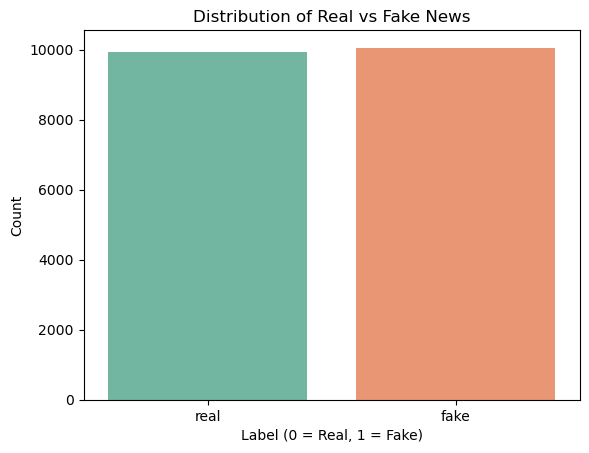

label
fake    0.5028
real    0.4972
Name: proportion, dtype: float64

In [7]:
# Binary label distribution
sns.countplot(x='label', data=dataset, palette='Set2')
plt.title('Distribution of Real vs Fake News')
plt.xlabel('Label (0 = Real, 1 = Fake)')
plt.ylabel('Count')
plt.show()

# Optional: value counts
dataset['label'].value_counts(normalize=True)


## Step 2: Exploratory Data Analysis (EDA)
### 2.1: Category Distribution

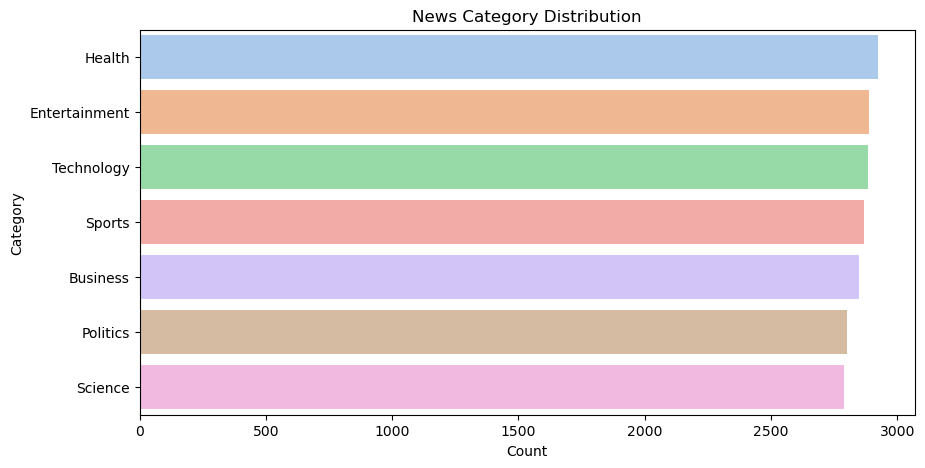

In [8]:
# Plot distribution of categories
plt.figure(figsize=(10, 5))
sns.countplot(y='category', data=dataset, order=dataset['category'].value_counts().index, palette='pastel')
plt.title('News Category Distribution')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


### 2.2: Article Lengths

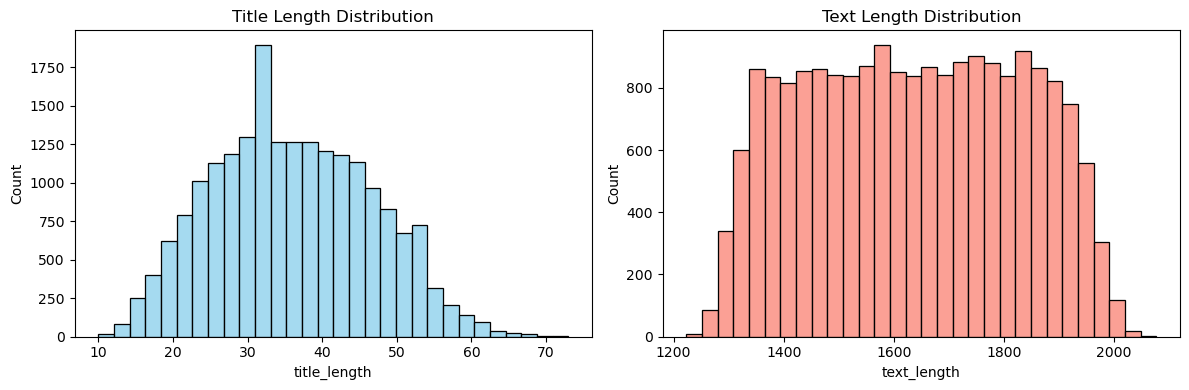

In [9]:
# Add new columns for lengths
dataset['title_length'] = dataset['title'].astype(str).apply(len)
dataset['text_length'] = dataset['text'].astype(str).apply(len)

# Plot text length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(dataset['title_length'], bins=30, color='skyblue')
plt.title('Title Length Distribution')

plt.subplot(1, 2, 2)
sns.histplot(dataset['text_length'], bins=30, color='salmon')
plt.title('Text Length Distribution')

plt.tight_layout()
plt.show()

### 2.3: Missing Values (Heatmap)

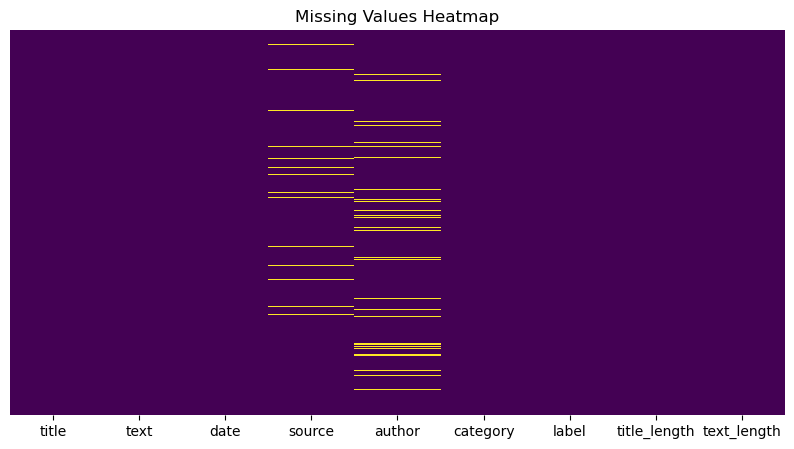

In [10]:
# Visualize missing data
plt.figure(figsize=(10, 5))
sns.heatmap(dataset.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

### 2.4: Top Sources & Authors (Drop NAs first)

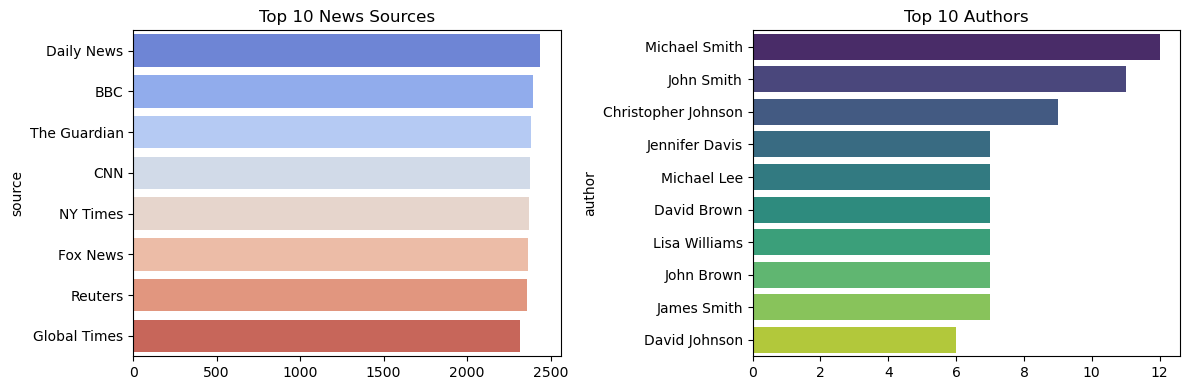

In [11]:
# Drop rows with missing for plotting
source_counts = dataset['source'].dropna().value_counts().head(10)
author_counts = dataset['author'].dropna().value_counts().head(10)

# Plot source distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.barplot(x=source_counts.values, y=source_counts.index, palette='coolwarm')
plt.title('Top 10 News Sources')

plt.subplot(1, 2, 2)
sns.barplot(x=author_counts.values, y=author_counts.index, palette='viridis')
plt.title('Top 10 Authors')

plt.tight_layout()
plt.show()


### 2.5: WordClouds for Real vs Fake Titles

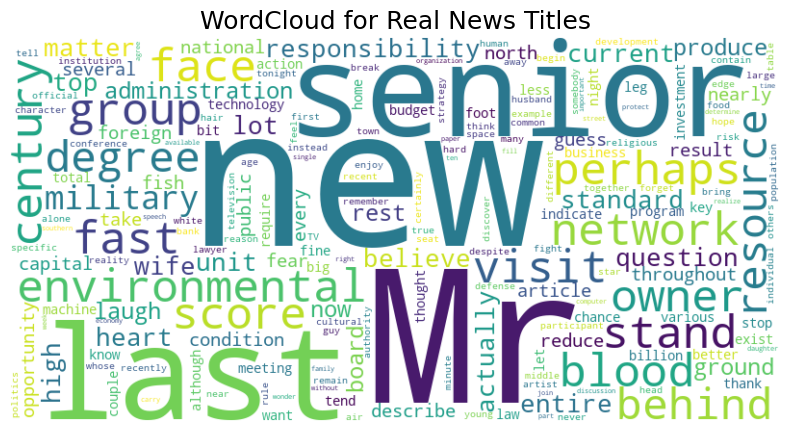

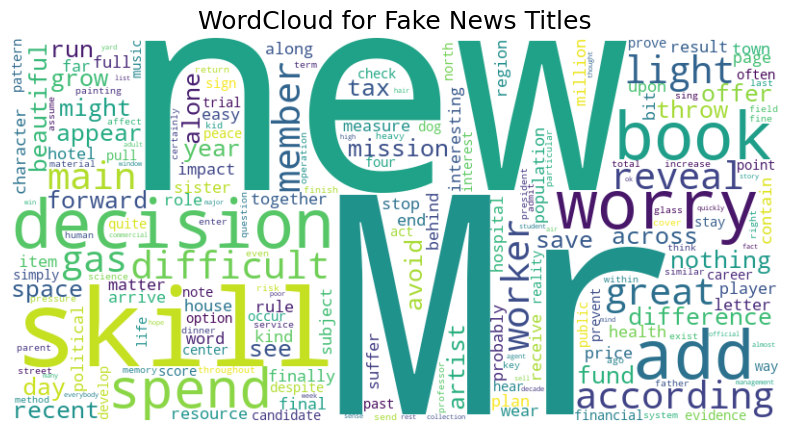

In [12]:
from wordcloud import WordCloud, STOPWORDS

def generate_wordcloud(text, title=None):
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords=STOPWORDS).generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=18)
    plt.show()

# Wordclouds
generate_wordcloud(dataset[dataset['label'] == 'real']['title'].astype(str), title='WordCloud for Real News Titles')
generate_wordcloud(dataset[dataset['label'] == 'fake']['title'].astype(str), title='WordCloud for Fake News Titles')


### 2.6: Compute Correlation Matrix

In [13]:
# Select numerical features
correlation_features = ['title_length', 'text_length']
correlation_data = dataset[correlation_features + ['label']]

# If 'label' is string type, convert to int
if correlation_data['label'].dtype == 'object':
    correlation_data['label'] = correlation_data['label'].map({'real': 0, 'fake': 1})

# Compute correlation matrix
corr_matrix = correlation_data.corr()

# Display the matrix
print(corr_matrix)


              title_length  text_length     label
title_length      1.000000    -0.002255 -0.012995
text_length      -0.002255     1.000000 -0.007563
label            -0.012995    -0.007563  1.000000


C:\Users\egeeb\AppData\Local\Temp\ipykernel_9468\3950528003.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correlation_data['label'] = correlation_data['label'].map({'real': 0, 'fake': 1})


### 2.6.2: Plot Correlation Heatmap

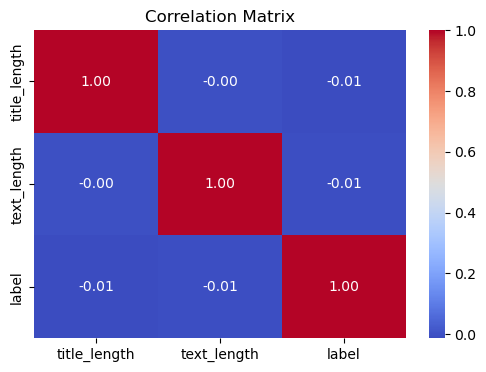

In [14]:
# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Step 3: Text Preprocessing
Tasks to be performed:
- Lowercasing

- Removing punctuation, digits, and stopwords

- Lemmatization

- Combining title and text into a single field

### 3.1: Setup & Imports

In [15]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egeeb\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\egeeb\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\egeeb\AppData\Roaming\nltk_data...


### 3.2: Define Text Cleaning Function

In [17]:
def clean_text(text):
    if pd.isnull(text):
        return ""
    # Lowercase
    text = text.lower()
    # Remove punctuation and digits
    text = re.sub(f"[{string.punctuation}0-9]", " ", text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(cleaned)

### 3.3: Apply Cleaning

In [18]:
# Combine title and text for full context
dataset['full_text'] = dataset['title'].astype(str) + " " + dataset['text'].astype(str)

# Apply cleaning
dataset['clean_text'] = dataset['full_text'].apply(clean_text)


### 3.4: Preview the Cleaned Text

In [19]:
# Preview
dataset[['full_text', 'clean_text']].sample(3).T


,11405,13950,11085
full_text,Thousand majority example whole road. past dar...,Interest project behind condition it. especial...,Able seem enough red card serve. seek story di...
clean_text,thousand majority example whole road past dark...,interest project behind condition especially s...,able seem enough red card serve seek story dis...


At this point, we’ve created a cleaned version of the text. We’re now ready to vectorize this and move on to "Feature Engineering & Text Vectorization".